In [1]:
%pylab inline
import homer
import pandas as pd
import numpy as np
import dask.bag as db
from dask.diagnostics import ProgressBar
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import json
from dask.diagnostics import visualize
import dask
import pickle
from itertools import combinations
import re
import dateutil.parser
from nltk.tokenize import RegexpTokenizer
import ujson
import dask.dataframe as dd
import itertools
from dask import delayed
from bokeh.io import output_notebook
import collections
import glob
output_notebook()

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
dates = [20150615]
thresholds = [10]
tw_files='tests/resources/small_tw_file*.gz'


In [2]:
dates = [20150615]
thresholds = [10]
tw_files=['/Users/houghton/Desktop/tw/posts_sample_20150615_162235_aa.gz',
          '/Users/houghton/Desktop/tw/posts_sample_20150615_162235_aa.gz']


In [2]:
#dates = [20150615]
thresholds = [10]
tw_files='/Users/houghton/Desktop/tw/posts_sample_201506*.gz'         


In [23]:
dates = [20150615]
thresholds = [10]
tw_files='/Users/houghton/Desktop/tw/posts_sample_20150615_162235_a*.gz'      

In [3]:
dates = [20150615, 20150616, 20150617, 20150618, 20150619, 20150620, 
         20150621, 20150622, 20150623, 20150624, 20150625]

sw_file = "homer/stopwords.pickle"
tw_stopwords = pickle.load(open(sw_file, "rb"))

tokenizer = RegexpTokenizer(r'\w+')
matcher = re.compile(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*')

languages = ['en']
def fold_pairs(counter, json_string):
    parsed_json = ujson.loads(json_string)
    if ('lang' in parsed_json and
            'text' in parsed_json and
            parsed_json['lang'] in languages):
        text = parsed_json['text'].lower()

        # remove hyperlinks
        text = matcher.sub('', text)

        # tokenize, dropping punctuation
        tokens = tokenizer.tokenize(text)  # this should release GIL - be ok for parallelization

        # drop stopwords
        tokens = filter(lambda x: x not in tw_stopwords, tokens)

        date = int(dateutil.parser.parse(parsed_json['created_at']).strftime("%Y%m%d"))
        
        if date not in counter:
            counter[date] = collections.Counter()
        for pair in combinations(tokens, 2):
            counter[date][tuple(sorted(pair))] += 1

    return counter


In [4]:
def delayed_add

def merge_folds(a, b):         
    return {date: a[date] + b[date] for date in dates}


# def merge_folds(a, b):
#     if isinstance(a, dict):
#         counters_series_list = [pd.Series(c) for c in a.values() if len(c)]
#         a = dd.from_pandas(pd.concat(counters_series_list, keys=a.keys()))  
        
#     if isinstance(b, dict):
#         b = dd.from_pandas(
#                 pd.concat(list(pd.Series(b.values())), keys=b.keys()))
        
    
        

In [6]:
lines = db.read_text(tw_files, compression='gzip', collection=True)

initial_counter = {date:collections.Counter() for date in dates}
counters = lines.fold(binop=fold_pairs, combine=merge_folds, initial=initial_counter)

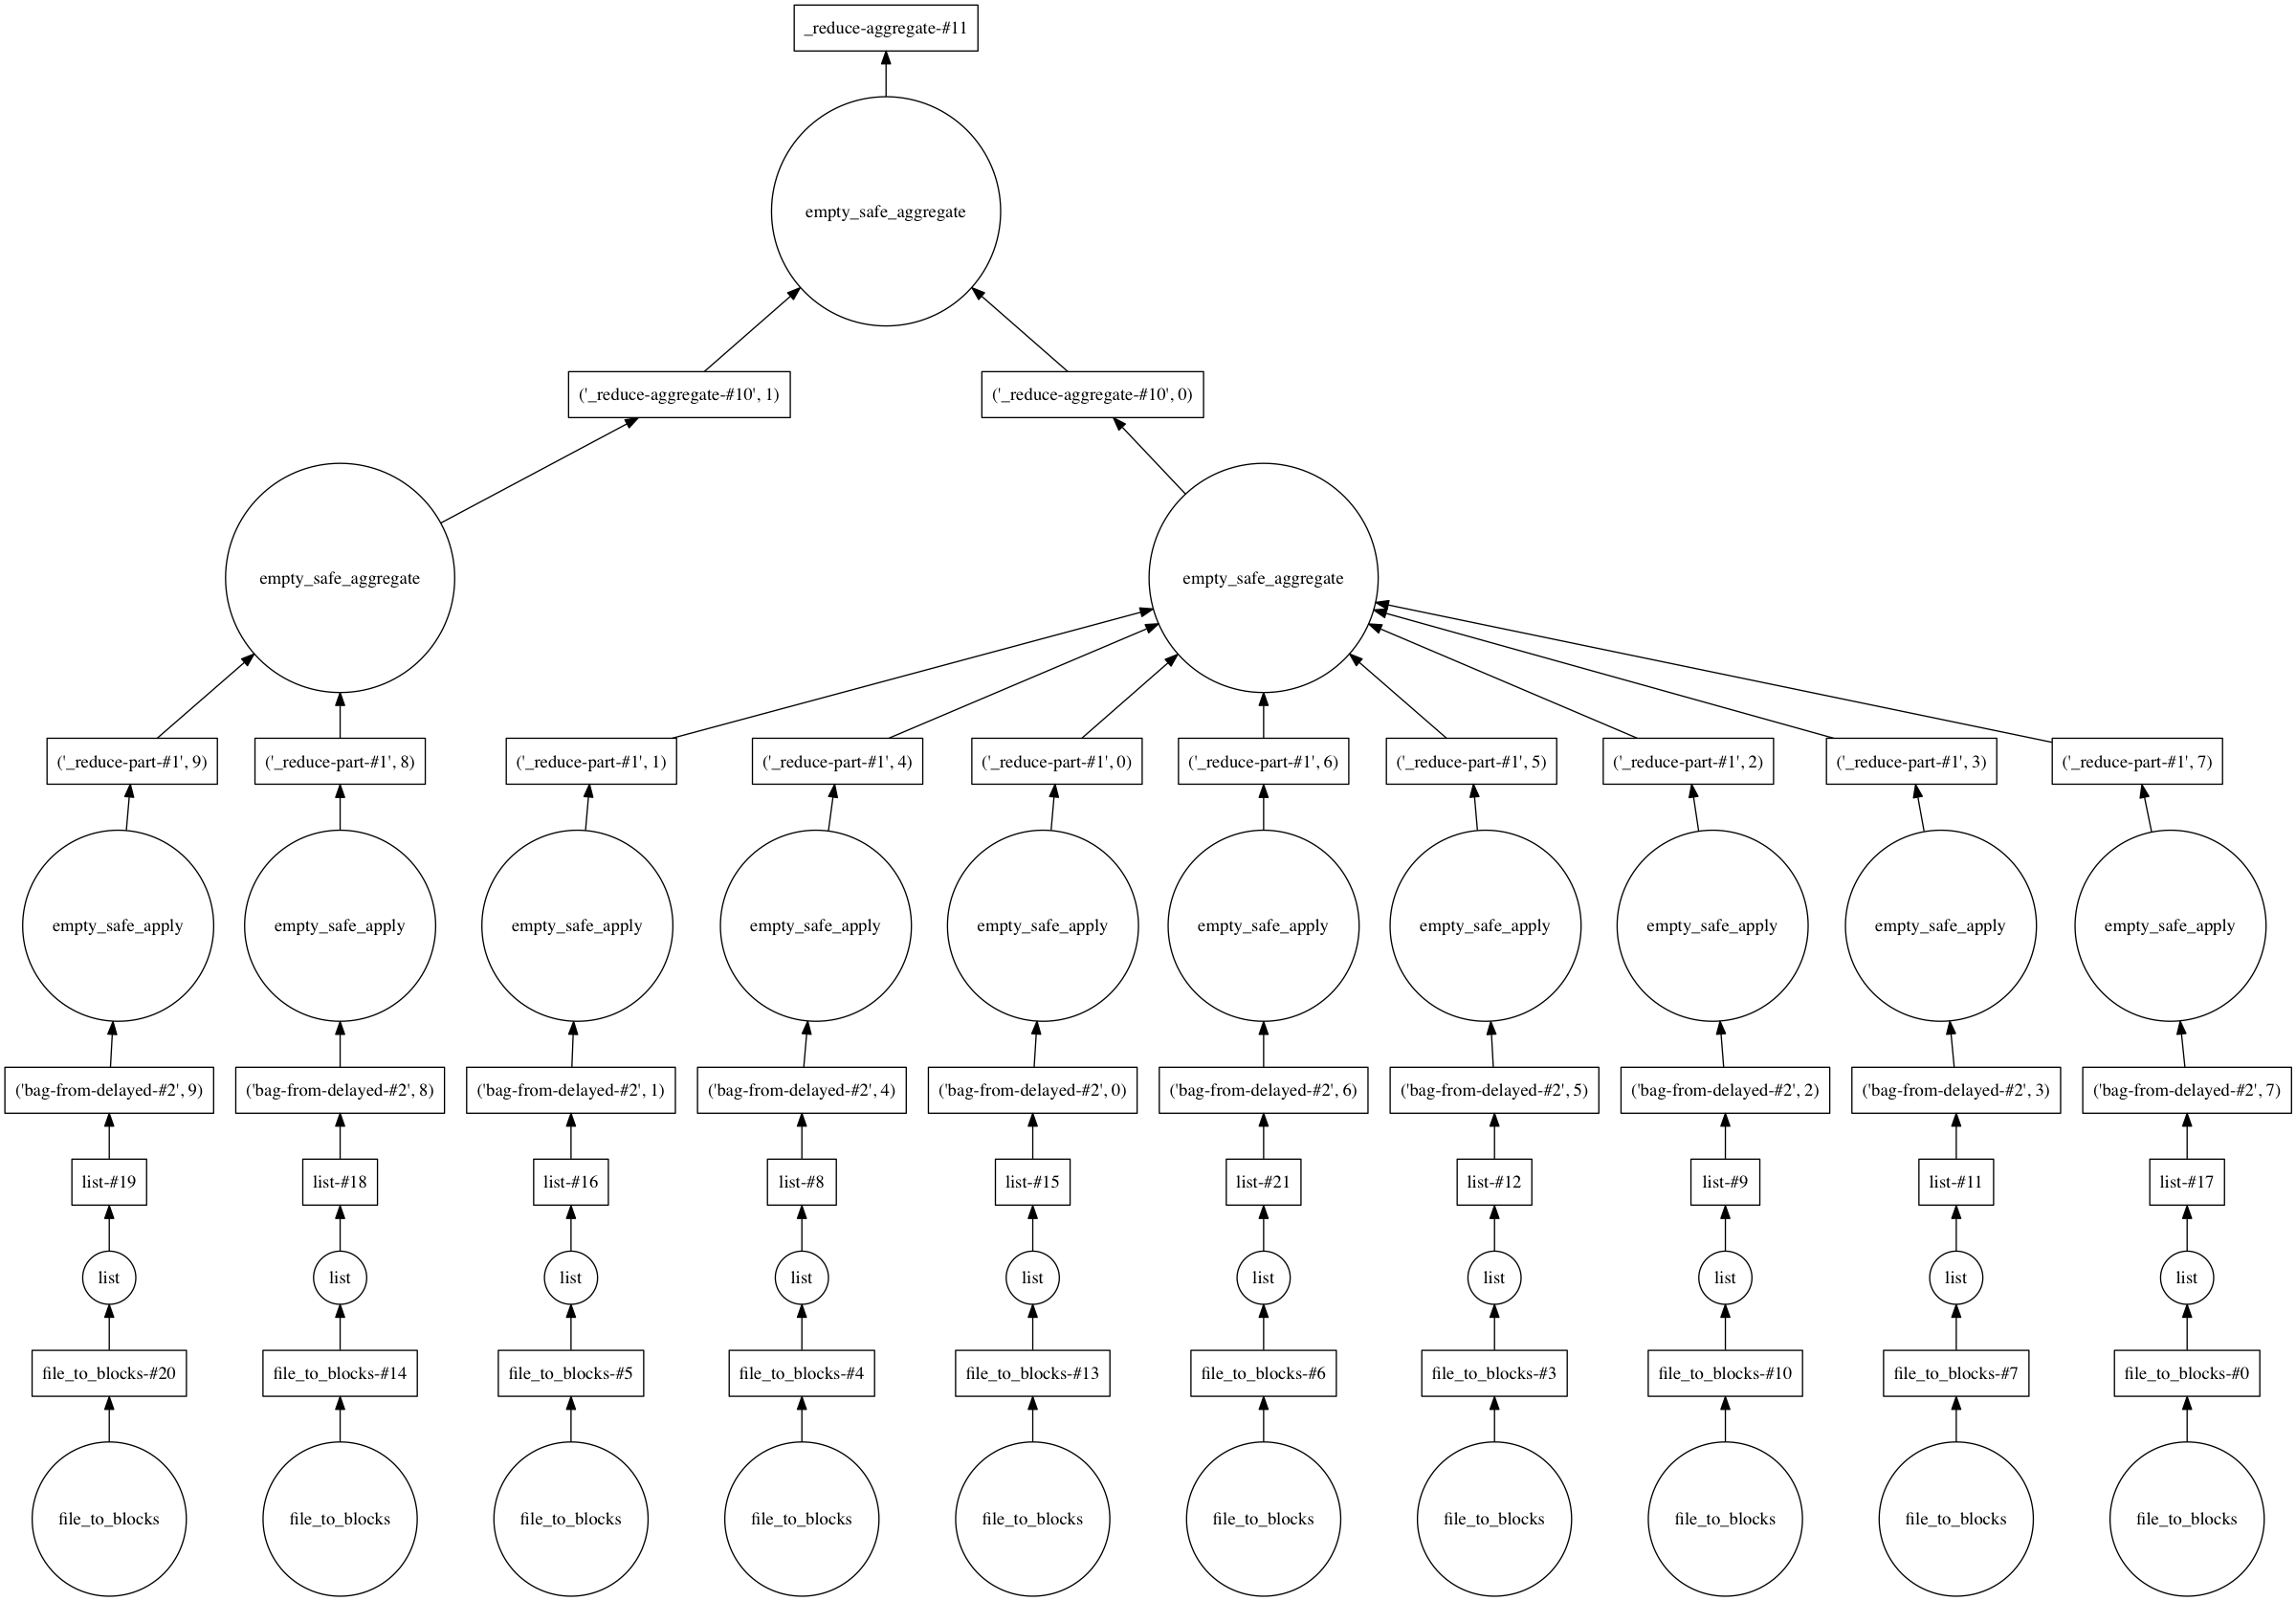

In [32]:
counters.visualize()

In [7]:
with Profiler() as prof, ResourceProfiler(dt=5) as rprof, CacheProfiler() as cprof:
    counts = counters.compute()
visualize([prof, rprof, cprof])     

Column(id='f147a038-bb25-4c60-a0d1-032eaebecce4', ...)

In [31]:
a = counts
counters_series_list = [pd.Series(c) for c in a.values() if len(c)]
a = dd.from_pandas(pd.concat(counters_series_list, keys=a.keys()))

NotImplementedError: Dask does not support MultiIndex Dataframes.

In [30]:
pd.concat([pd.Series(c) for c in counts.values() if len(c)], keys=counts.keys())

20150624  0           1              2
                      13             1
                      14             1
                      15             1
                      21             1
                      4              1
                      49             1
                      58             1
                      6              1
                      7              8
                      75             1
                      77             1
                      9              1
                      bags           1
                      become         1
                      big            1
                      buried         1
                      cvsdeals       1
                      date           2
                      dubs           1
                      family         1
                      game           1
                      improved       1
                      imrkil         1
                      leading        1
                      lef

In [28]:
pd.Series(counts)

KeyError: 0

In [13]:
series.head()

0  1     2
   13    1
   14    1
   15    1
   21    1
dtype: int64

In [15]:
index = series.index

In [18]:
pd.concat([series, series], keys=[111,222])

111  0           1              2
                 13             1
                 14             1
                 15             1
                 21             1
                 4              1
                 49             1
                 58             1
                 6              1
                 7              8
                 75             1
                 77             1
                 9              1
                 bags           1
                 become         1
                 big            1
                 buried         1
                 cvsdeals       1
                 date           2
                 dubs           1
                 family         1
                 game           1
                 improved       1
                 imrkil         1
                 leading        1
                 left           1
                 obstacles      1
                 point          1
                 points         1
              

In [48]:
with ProgressBar():
    counts = counters.compute()

[########################################] | 100% Completed |  1hr 43min 41.8s


In [5]:
threshold=50
def find_clusters(date, counter, threshold):
    series = pd.Series(counter)
    over_thresh = series[series>threshold]
    over_thresh.to_hdf('/Users/houghton/Desktop/tw/charleston/test_%i_%i.hdf' %(date, threshold), '/clusters', dropna=True)

    #clusters = homer.clusterer.find_clusters(pd.DataFrame(pairs))
    #clusters.to_hdf('/Users/houghton/Desktop/tw/charleston/test_%i_%i.hdf' %(date, threshold), '/clusters', dropna=True)
    
lazy_find_clusters = delayed(find_clusters)

In [ ]:
with ProgressBar():
    collector = []
    for date, counter in counters.compute().items():
        collector.append(lazy_find_clusters(date, counter, threshold))
    dask.compute(*collector)

[                                        ] | 1% Completed |  1min 13.6s

In [3]:
#tw_files='tests/resources/testfile.txt'
# tw_files=['/Users/houghton/Desktop/tw/posts_sample_20150615_162235_aa.gz',
#            '/Users/houghton/Desktop/tw/posts_sample_20150615_162235_aa.gz']

# tw_files='/Users/houghton/Desktop/tw/posts_sample_20150615_162235_a*.gz'

tw_files='/Users/houghton/Desktop/tw/posts_sample_201506*.gz'
languages=['en']

save_threshold = 10

sw_file = "homer/stopwords.pickle"
tw_stopwords = pickle.load(open(sw_file, "rb"))

In [4]:
df = homer.parser.get_weighted_edgelist(tw_files, languages=['en'], save_threshold=10)

In [5]:
groups = df.groupby('Date')

In [6]:

clusters = groups.apply(homer.clusterer.find_clusters_for_any_threshold)

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/dataframe/groupby.py:786: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [7]:
cluster = groups.apply(lambda x: homer.find_clusters_over_threshold(x, 10))

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/dataframe/groupby.py:786: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


ValueError: Metadata inference failed in `groupby.apply(lambda)`.

Original error is below:
------------------------
IndexError('list index out of range',)

Traceback:
---------
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/dataframe/utils.py", line 154, in raise_on_meta_error
    yield
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/dataframe/groupby.py", line 789, in apply
    meta = self._meta_nonempty.apply(func)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/groupby.py", line 694, in apply
    return self._python_apply_general(f)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/groupby.py", line 698, in _python_apply_general
    self.axis)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/groupby.py", line 1601, in apply
    res = f(group)
  File "<ipython-input-7-2324794ad3fb>", line 1, in <lambda>
    cluster = groups.apply(lambda x: homer.find_clusters_over_threshold(x, 10))
  File "/Users/houghton/Google Drive/Academic Projects/HOMER/homer/homer/clusterer.py", line 183, in find_clusters_over_threshold
    clusters = find_clusters(uw_el[['W1', 'W2']])
  File "/Users/houghton/Google Drive/Academic Projects/HOMER/homer/homer/clusterer.py", line 80, in find_clusters
    mapping = pd.read_csv(map_filename[0], sep=' ', header=None,


In [63]:
# frequencies on daily, parse json separate
dates = ['20160618']
thresholds = [10, 15]

tokenizer = RegexpTokenizer(r'\w+')
def find_pairs(parsed_json):
    text = parsed_json['text'].lower()

    # remove hyperlinks
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    # tokenize, dropping punctuation
    tokens = tokenizer.tokenize(text)  # this should release GIL - be ok for parallelization

    # drop stopwords
    tokens = filter(lambda x: x not in tw_stopwords, tokens)

    date = dateutil.parser.parse(parsed_json['created_at']).strftime("%Y%m%d")

    sets = [tuple([date] + sorted(pair)) for pair in combinations(tokens, 2)]
    return sets

messages = db.read_text(tw_files, compression='gzip').map(ujson.loads)

def selector(msg):
    return 'lang' in msg and 'text' in msg and msg['lang'] in languages

selection = messages.filter(selector)
sets = selection.map(find_pairs).concat()

for date in dates:
    frequencies_on_date = delayed(sets.filter(lambda x: x[0] == date).frequencies())
    #for threshold in thresholds:
    #    above_threshold = frequencies_on_date.filter(lambda x: x[1]>threshold)
    #    pairs = above_threshold.pluck([0][1], [0][2])
        
    break
    

In [65]:
# frequencies on daily, parse json integral
dates = [20150615]
thresholds = [10, 15]
languages = ['en']

tokenizer = RegexpTokenizer(r'\w+')
matcher = re.compile(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*')

def find_pairs(json_string):
    msg = ujson.loads(json_string)
    if 'lang' in msg and 'text' in msg and msg['lang'] in languages:
    
        text = msg['text'].lower()

        # remove hyperlinks
        text = matcher.sub('', text)

        # tokenize, dropping punctuation
        tokens = tokenizer.tokenize(text)  # this should release GIL - be ok for parallelization

        # drop stopwords
        tokens = filter(lambda x: x not in tw_stopwords, tokens)

        date = int(dateutil.parser.parse(msg['created_at']).strftime("%Y%m%d"))

        sets = [tuple([date] + sorted(pair)) for pair in combinations(tokens, 2)]
        return sets
    
    else:
        return []


sets = db.read_text(tw_files, compression='gzip').map(find_pairs).concat()


for date in dates:
    sets_on_date = sets.filter(lambda x: x[0] == date)
    frequencies_on_date = sets_on_date.frequencies()
    for threshold in thresholds:
        above_threshold = frequencies_on_date.filter(lambda x: x[1]>threshold)
        pairs = above_threshold.pluck([0]).pluck([1, 2])
        break
    break

#frequencies_on_date.take(3)
    

In [52]:
# frequencies on whole set
dates = [20150615]
thresholds = [10, 15]
languages = ['en']

tokenizer = RegexpTokenizer(r'\w+')
def find_pairs(json_string):
    msg = ujson.loads(json_string)
    if 'lang' in msg and 'text' in msg and msg['lang'] in languages:
    
        text = msg['text'].lower()

        # remove hyperlinks
        text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

        # tokenize, dropping punctuation
        tokens = tokenizer.tokenize(text)  # this should release GIL - be ok for parallelization

        # drop stopwords
        tokens = filter(lambda x: x not in tw_stopwords, tokens)

        date = int(dateutil.parser.parse(msg['created_at']).strftime("%Y%m%d"))

        sets = [tuple([date] + sorted(pair)) for pair in combinations(tokens, 2)]
        return sets
    
    else:
        return []


    

sets = db.read_text(tw_files, compression='gzip').map(find_pairs).concat()
frequencies = sets.frequencies()

template = pd.DataFrame([{'Date': 20170121, 'W1': 'Toad', 'W2': u'Bug', 'Count': 21}],
                                columns=['Date', 'W1', 'W2', 'Count'])

collector = []
for date, threshold in itertools.product(dates, thresholds):
    selection = frequencies.filter(lambda x: x[0][0] == date and x[1]>threshold)
    expand = frequencies.map(lambda x: (x[0][0], x[0][1], x[0][2], x[1]))
    uw_df = expand.to_dataframe(template)
    collector.append(delayed(homer.clusterer.find_clusters(uw_df[['W1', 'W2']]).assign(Threshold=threshold)))

clusters = dd.from_delayed(collector, meta=template)
clusters.to_hdf('/Users/houghton/Desktop/tw/charleston/test.hdf', '/clusters', dropna=True)

visualize([prof, rprof, cprof])     

IndexError: list index out of range

In [ ]:
# via dataframe
#data goes into the 25th of the month...

dates = [20150616, 20150617, 20150618, 20150619, 20150620, 20150621, 20150622]
thresholds = [120]

tokenizer = RegexpTokenizer(r'\w+')
def find_pairs(json_string):
    msg = ujson.loads(json_string)
    if 'lang' in msg and 'text' in msg and msg['lang'] in languages:
    
        text = msg['text'].lower()

        # remove hyperlinks
        text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

        # tokenize, dropping punctuation
        tokens = tokenizer.tokenize(text)  # this should release GIL - be ok for parallelization

        # drop stopwords
        tokens = filter(lambda x: x not in tw_stopwords, tokens)

        date = int(dateutil.parser.parse(msg['created_at']).strftime("%Y%m%d"))

        sets = [tuple([date] + sorted(pair)) for pair in combinations(tokens, 2)]
        return sets
    
    else:
        return []



sets = db.read_text(tw_files, compression='gzip').map(find_pairs).concat()
frequencies = sets.frequencies()
expand = frequencies.map(lambda x: (x[0][0], x[0][1], x[0][2], x[1]))

template = pd.DataFrame([{'Date': 20170121, 'W1': 'Toad', 'W2': u'Bug', 'Count': 21}],
                            columns=['Date', 'W1', 'W2', 'Count'])

weighted_df = expand.to_dataframe(template)

lazy_find_clusters = delayed(homer.clusterer.find_clusters)

collector = []
for date, threshold in itertools.product(dates, thresholds):
    on_date = weighted_df[weighted_df['Date']==date]
    unweighted_df = on_date[on_date['Count'] >= threshold][['W1', 'W2']]
    collector.append(lazy_find_clusters(unweighted_df).assign(Threshold=threshold))


template2 = pd.DataFrame(data=[{'Set':'Ho Bean', 'k':5, 'threshold': 10, 'Date':20170101}],
                         columns=['Set', 'k', 'threshold', 'Date'])    

clusters = dd.from_delayed(collector, meta=template2)
#clusters.to_hdf('/Users/houghton/Desktop/tw/charleston/test.hdf', '/clusters', dropna=True)
    
#visualize([prof, rprof, cprof])     

In [ ]:
with ProgressBar():
    clusters.to_hdf('/Users/houghton/Desktop/tw/charleston/full_set_t100.hdf', '/clusters', dropna=True)

[####################################    ] | 90% Completed |  3hr 31min  3.9s

In [89]:
with Profiler() as prof, ResourceProfiler(dt=5) as rparof, CacheProfiler() as cprof:
    clusters.to_hdf('/Users/houghton/Desktop/tw/charleston/full_set.hdf', '/clusters', dropna=True)
visualize([prof, rprof, cprof])     

Process _Tracker-230:
psutil.NoSuchProcess: psutil.NoSuchProcess process no longer exists (pid=1124)
Traceback (most recent call last):
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/psutil/_psosx.py", line 244, in wrapper
    return fun(self, *args, **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/psutil/_psosx.py", line 317, in memory_info
    rss, vms, pfaults, pageins = cext.proc_memory_info(self.pid)
ProcessLookupError: [Errno 3] No such process

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/diagnostics/profile.py", line 231, in run
    mem = sum(p.memory_info().rss for p in ps) / 1e6
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/diagnostics/

Column(id='d48e10d4-b0aa-427b-85bb-6fdab524a636', ...)

In [92]:
clusters.npartitions

1

In [5]:
clusters.visualize()

KeyboardInterrupt: 

In [ ]:
dask.compute

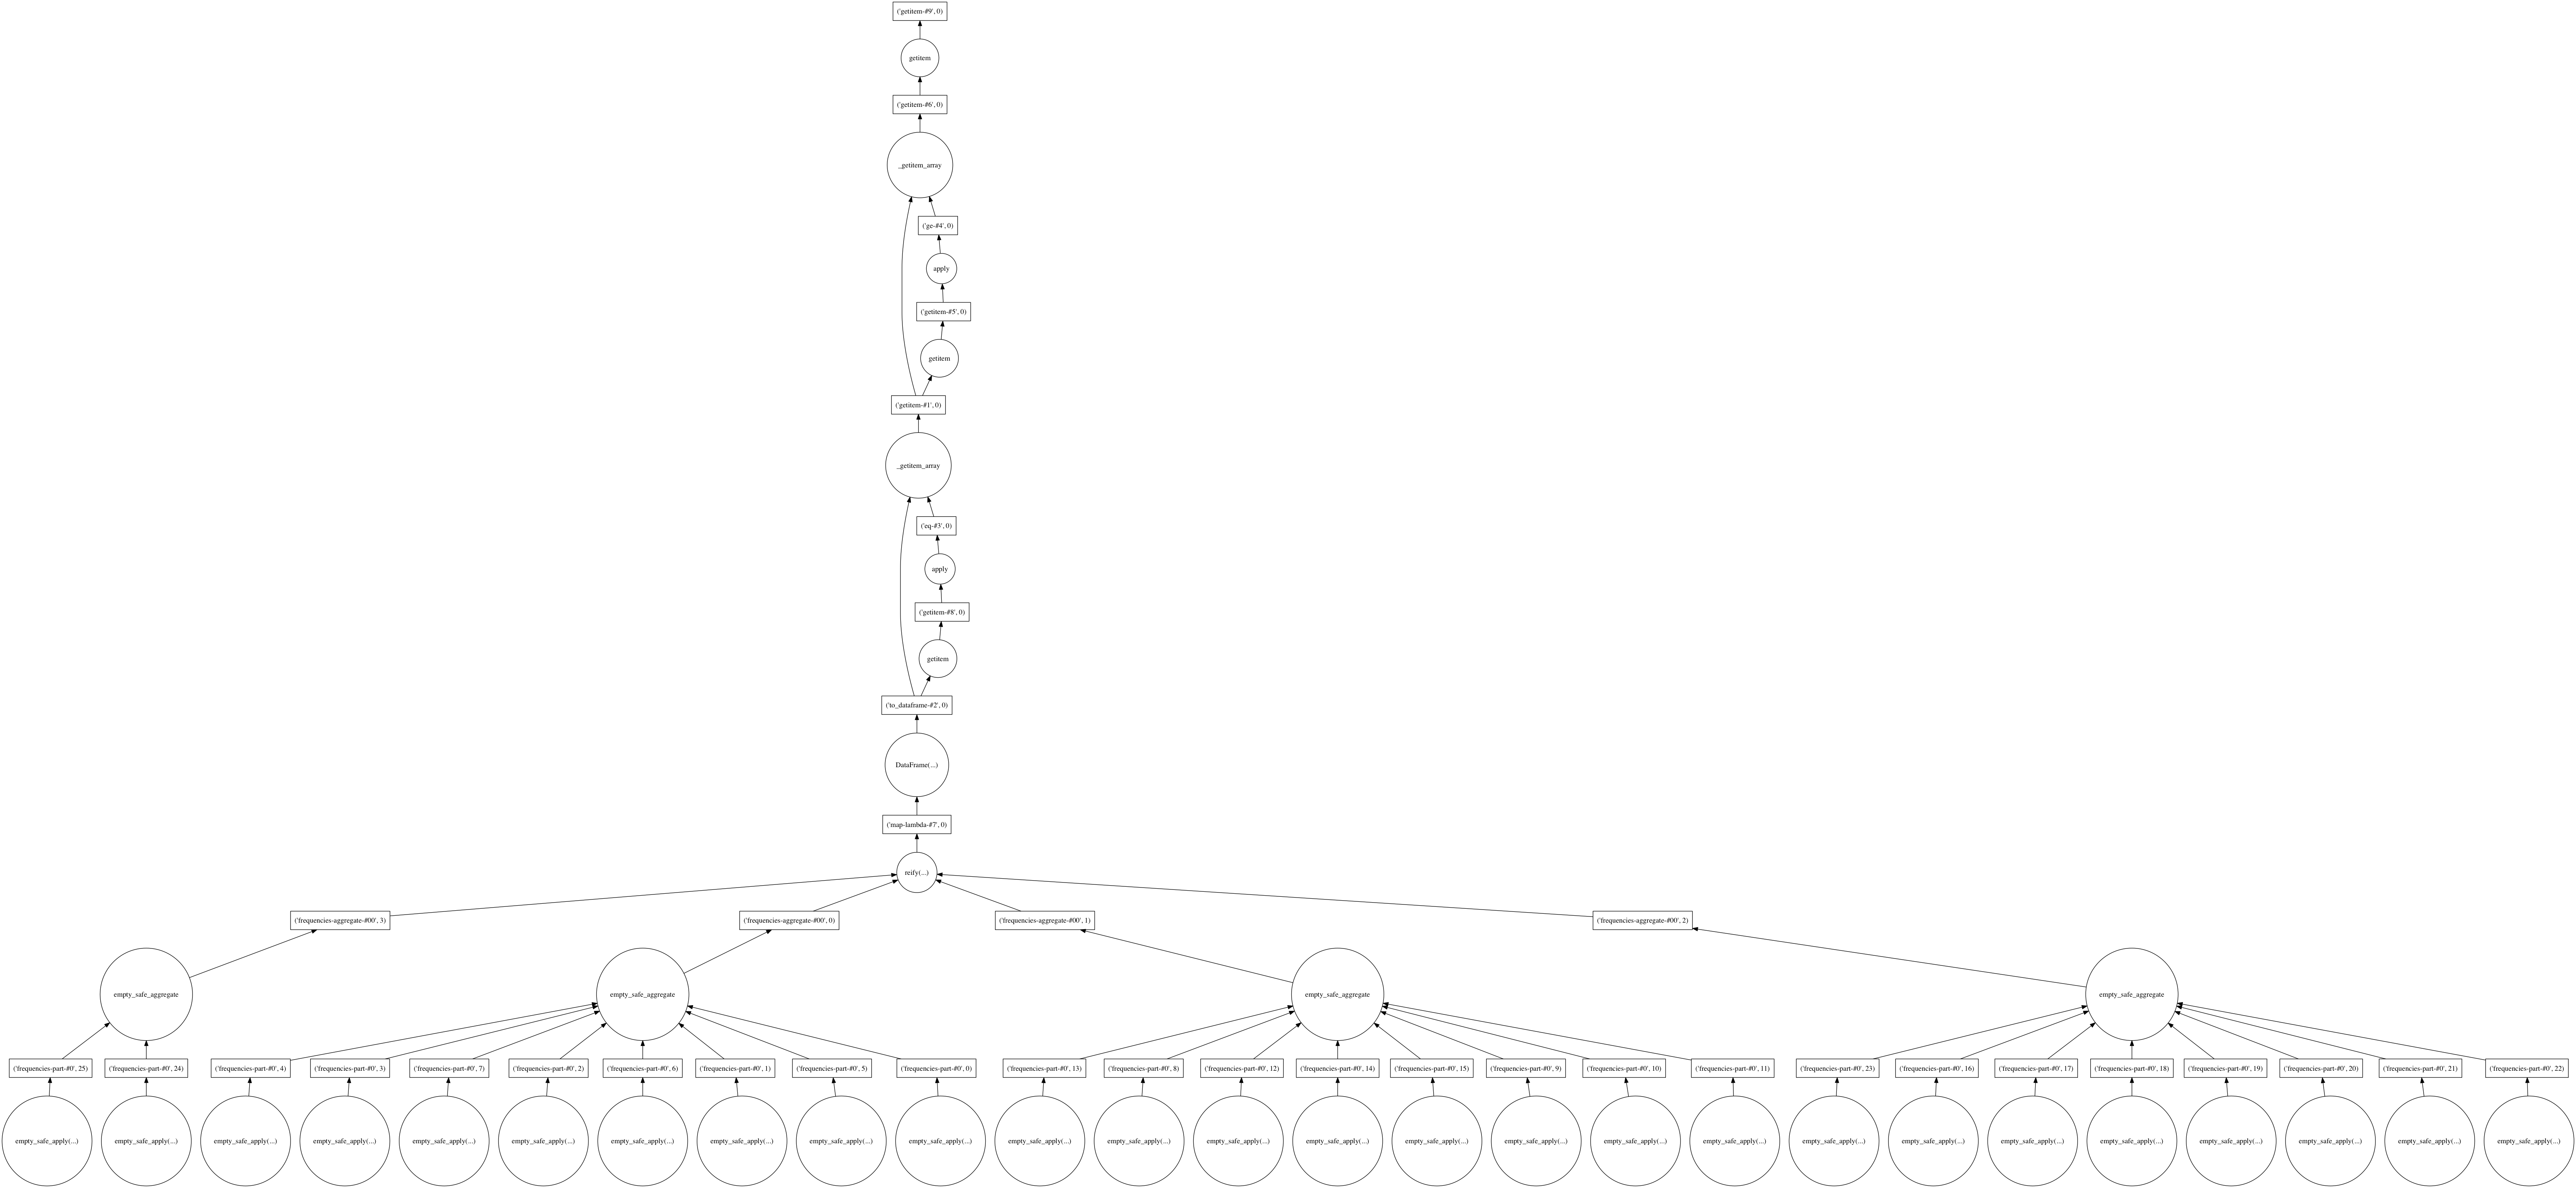

In [57]:
unweighted_df.visualize()

In [24]:
clusters.head()

Set   k  Threshold
0  check hey description secrets detail find 000 ...  10         10
1  notifica iharry_styls gain follow retweets tur...  10         10
2  baldwin hailey june horny4dabiebs justin justi...  10         10
3  tweet follow followers day feel live video eve...  10         10
4  bleacherreport old light dressed ht goes prank...  10         10

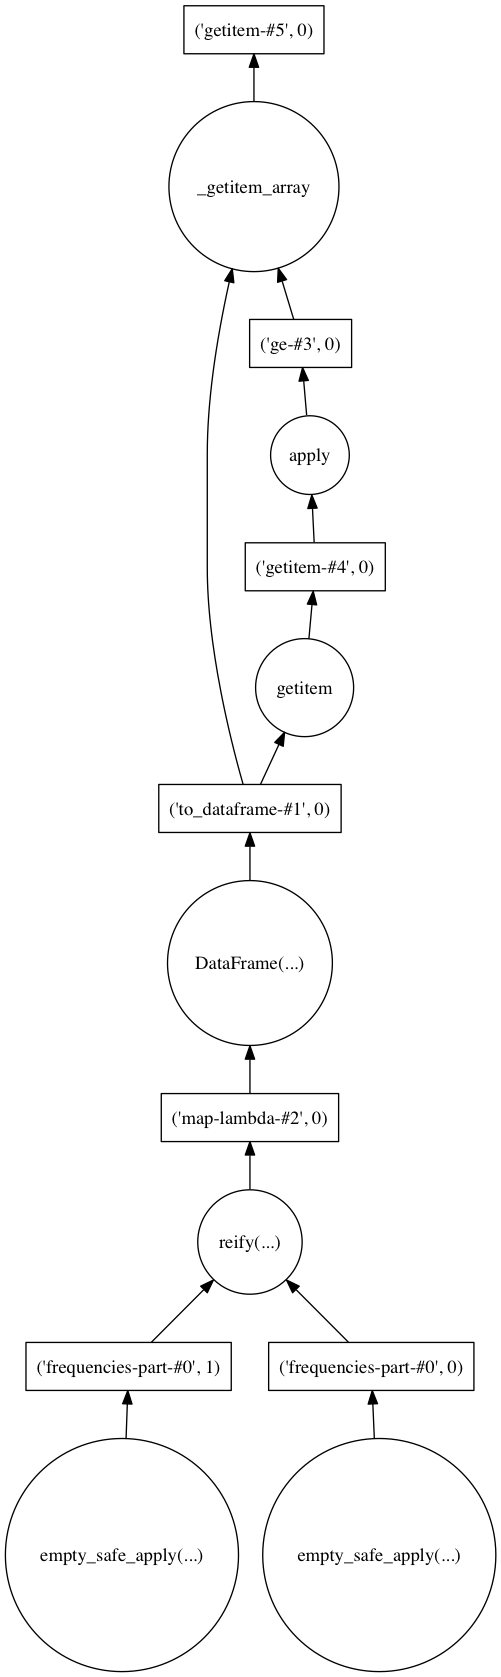

In [22]:
unweighted_df.visualize()

In [ ]:
thresholds = weighted_edge_list['Count'].unique()
clusters_collector = []
for t in np.array(thresholds):
    if t < min_threshold:
        continue
    cluster = delayed(find_clusters_over_threshold)(weighted_edge_list, t)
    clusters_collector.append(cluster)

clusters = dd.from_delayed(clusters_collector)
return clusters

In [17]:
template = pd.DataFrame(data=[{'Set':'Ho Bean', 'k':5, 'threshold': 10, 'Date':20170101}],
                        columns=['Set', 'k', 'threshold', 'Date'])

collector = []
for date in [20160618]:
    selection = w_el[w_el.Date == date]
    df = homer.clusterer.find_clusters_for_any_threshold(selection,
                                         min_threshold=10)

    df_2 = df.assign(Date=date)
    collector.append(df_2)

clusters = dd.from_delayed(collector, meta=template)        
#clusters = dd.concat(collector)        
#clusters = dd.concat(collector, interleave_partitions=True)
#clusters = clusters.repartition(npartitions=1)  # Todo: This partitioning is problematic
#clusters = clusters.reset_index(drop=True) #Todo: need to set an index which is unlikely to
# also be a word in a cluster.
#clusters.to_hdf(output_globstring, '/clusters', dropna=True)

IndexError: list index out of range

In [18]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    groups.Count.mean().compute()
visualize([prof, rprof, cprof]) 

Column(id='5d9db109-4ade-4022-a180-8d68d1e78a18', ...)

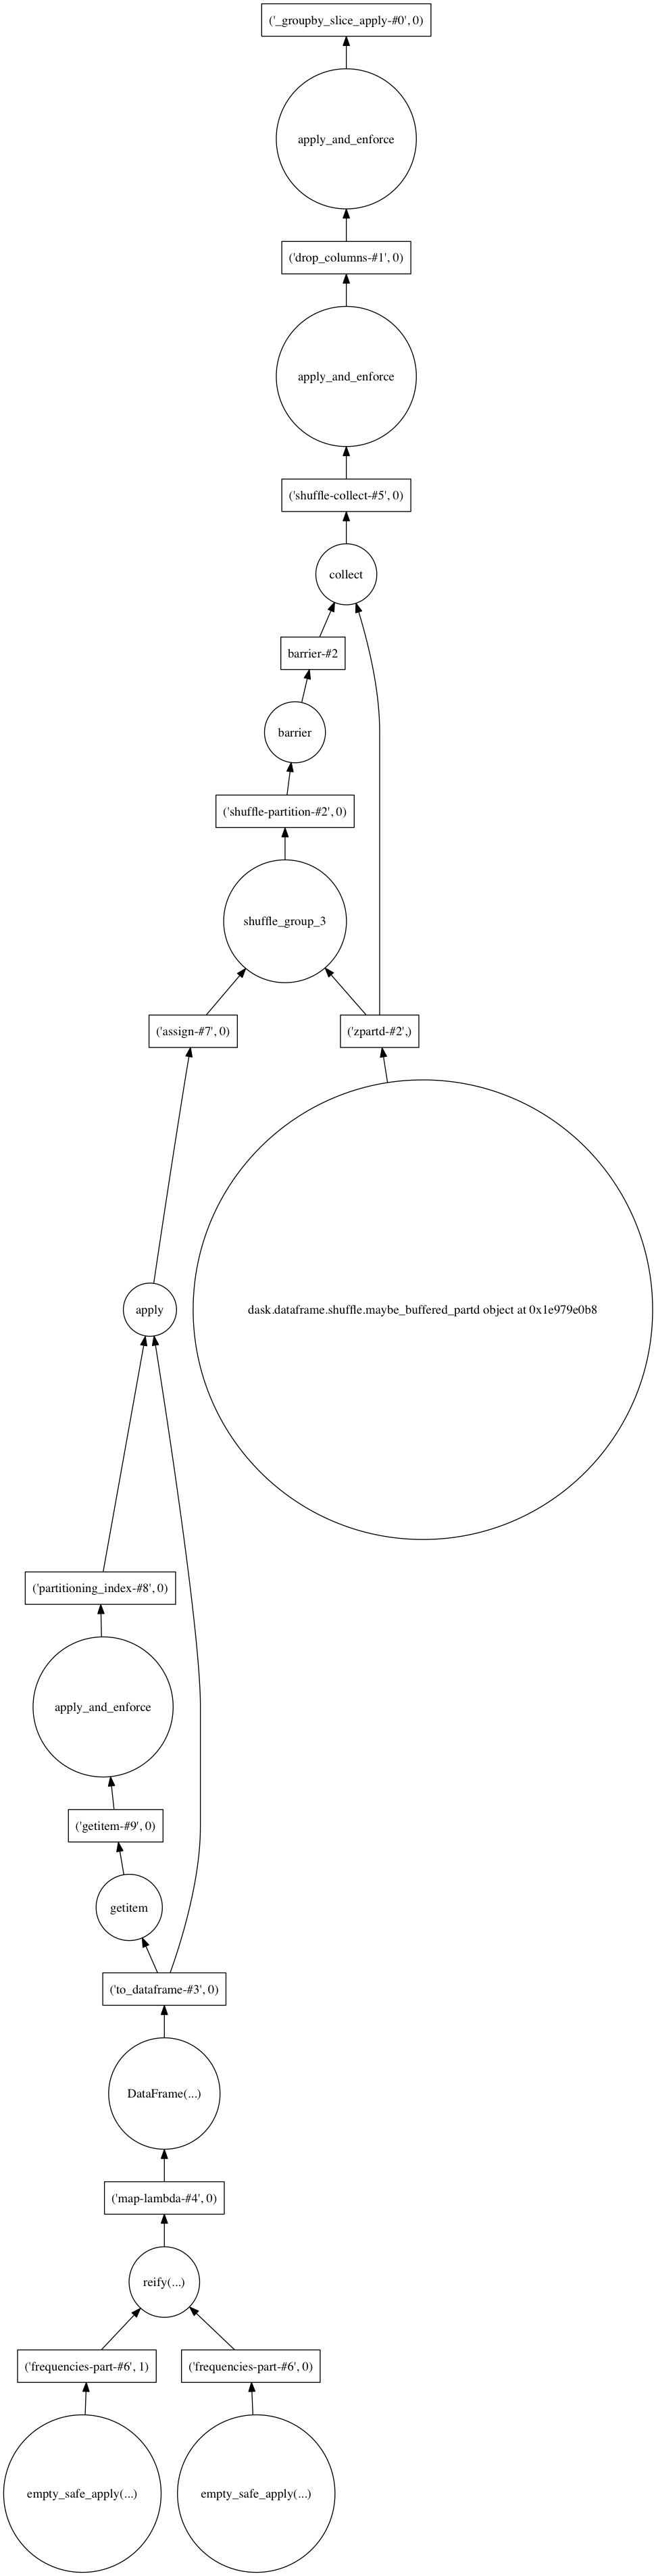

In [23]:
clusters.visualize()

In [24]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    clusters.compute()

Process _Tracker-4:
Traceback (most recent call last):
psutil.NoSuchProcess: psutil.NoSuchProcess process no longer exists (pid=81601)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/psutil/_psosx.py", line 244, in wrapper
    return fun(self, *args, **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/psutil/_psosx.py", line 317, in memory_info
    rss, vms, pfaults, pageins = cext.proc_memory_info(self.pid)
ProcessLookupError: [Errno 3] No such process

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/diagnostics/profile.py", line 231, in run
    mem = sum(p.memory_info().rss for p in ps) / 1e6
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/diagnostics/p

KeyError: 'find_clusters_over_threshold-ed564c5d-c0dc-444c-a8ef-552fe74feec8'

In [13]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    df.to_hdf('/Users/houghton/Desktop/tw/charleston/wel.hdf', key='/weighted_edge_list', dropna=True)

In [27]:
df.head()

Date     W1    W2  Count
0  20150615   love     r     10
1  20150615   hope  soon     22
2  20150615    day  feel     10
3  20150615   know   tho     12
4  20150615  black   one     12

In [33]:
df.categorize('Date')

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/dataframe/categorical.py:17: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  df[col] = pd.Categorical(df[col], categories=vals, ordered=False)


dd.DataFrame<_catego..., npartitions=1>

In [32]:
df.repartition(divisions=[0, 100])

ValueError: left side of old and new divisions are different

In [22]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    df.compute()

visualize([prof, rprof, cprof])  

Column(id='33857952-9aa9-4af3-a24e-17a0f0356de0', ...)

In [14]:
visualize([prof, rprof, cprof]) 

Column(id='a192dc30-c167-456e-8b82-2fd92efded03', ...)

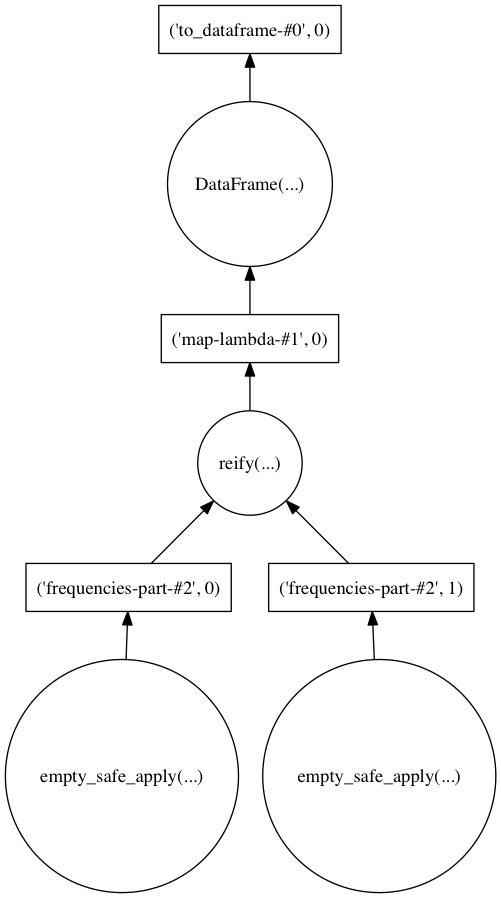

In [7]:
df = homer.get_weighted_edgelist(tw_files, languages=['en'], save_threshold=10)
df.visualize()

In [5]:
#with ProgressBar():
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    homer.build_weighted_edgelist_db(tw_files, 
                                     output_globstring='/Users/houghton/Desktop/tw/charleston/weighted_edgelists_*.hdf',
                                     save_threshold=10)

In [22]:
template = pd.DataFrame([{'Date': 20170121, 'W1': 'Toad', 'W2': u'Bug', 'Count': 21}],
                            columns=['Date', 'W1', 'W2', 'Count'])
save_threshold = 10

In [15]:


cooccurences = db.read_text(tw_files).map(homer.parser.get_message_cooccurences,
                                          languages=['en']).concat()
frequencies = cooccurences.frequencies()
over_threshold = frequencies.filter(lambda x: x[1] >= save_threshold)
expand = over_threshold.map(lambda x: (x[0][0], x[0][1], x[0][2], x[1]))
df = expand.to_dataframe(template)

In [16]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    df.compute()
    
visualize([prof, rprof, cprof])    

In [17]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Column(id='95195a84-1fa2-4f2c-abde-4081d6a07b04', ...)

In [4]:
with ProgressBar():
    df.head()

[########################################] | 100% Completed | 40.3s


In [27]:
template = pd.DataFrame([{'Date':20170121, 'W1':'Toad', 'W2':u'Bug', 'Count':21}], 
                        columns=['Date', 'W1', 'W2', 'Count'])

In [28]:
template

Date    W1   W2  Count
0  20170121  Toad  Bug     21

In [29]:
cooccurences = db.read_text(tw_files).map(homer.parser.get_message_cooccurences,
                                          languages=languages).concat()

#cooccurences.take(3)
frequencies = cooccurences.frequencies()

over_threshold = frequencies.filter(lambda x: x[1] >= keep_threshold)
expand = over_threshold.map(lambda x: (x[0][0], x[0][1], x[0][2], x[1]))
df = expand.to_dataframe(template)

#frequencies = cooccurences.frequencies()
# dicts = frequencies.map(
#        lambda x: {'Date': int(x[0][0]),
#                    'W1': str(x[0][1]),
#                    'W2': str(x[0][2]),
#                    'Count': int(x[1])})
#     df = dicts.to_dataframe()


with ProgressBar():
#with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    #out = over_threshold.take(3)
    #size = over_threshold.count().compute()
    df.head()
    
#print(size)

#out

[########################################] | 100% Completed | 40.6s


In [30]:
cooccurences = db.read_text(tw_files).map(homer.parser.get_message_cooccurences,
                                          languages=languages).concat()

#cooccurences.take(3)
frequencies = cooccurences.frequencies()

over_threshold = frequencies.filter(lambda x: x[1] >= keep_threshold)
expand = over_threshold.map(lambda x: (*x[0], x[1]))
df = expand.to_dataframe(template)

#frequencies = cooccurences.frequencies()
# dicts = frequencies.map(
#        lambda x: {'Date': int(x[0][0]),
#                    'W1': str(x[0][1]),
#                    'W2': str(x[0][2]),
#                    'Count': int(x[1])})
#     df = dicts.to_dataframe()


with ProgressBar():
#with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    #out = over_threshold.take(3)
    #size = over_threshold.count().compute()
    df.head()
    
#print(size)

#out

[########################################] | 100% Completed | 41.2s


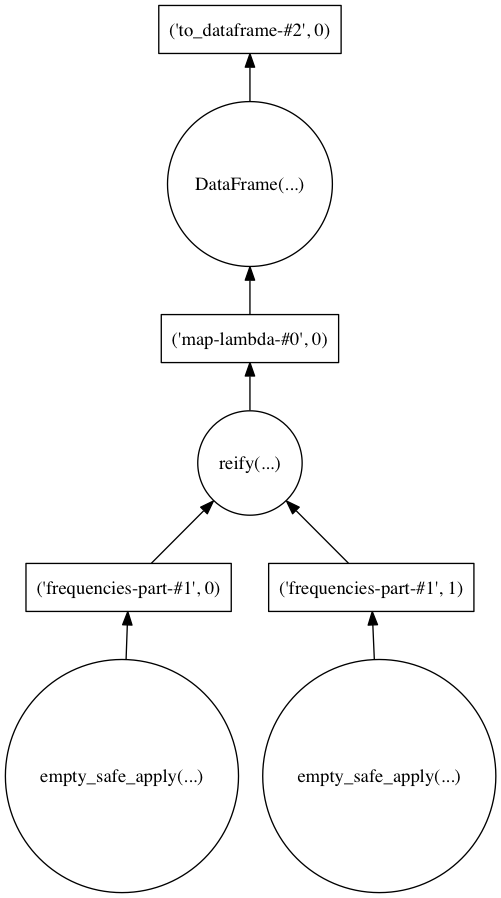

In [32]:
df.visualize()

In [13]:
df = over_threshold.to_dataframe(columns=[['Date', 'W1', 'W2'], 'Count'])

In [14]:
df.head()

(Date, W1, W2)  Count
0      (20150615, bitch, shit)     16
1       (20150615, 10, figure)     18
2  (20150615, niggas, survive)      6
3       (20150615, news, sale)      6
4    (20150615, bounce, visit)      8

In [5]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Column(id='b1ec197d-7e6e-4638-9fe2-3340fcaa335d', ...)

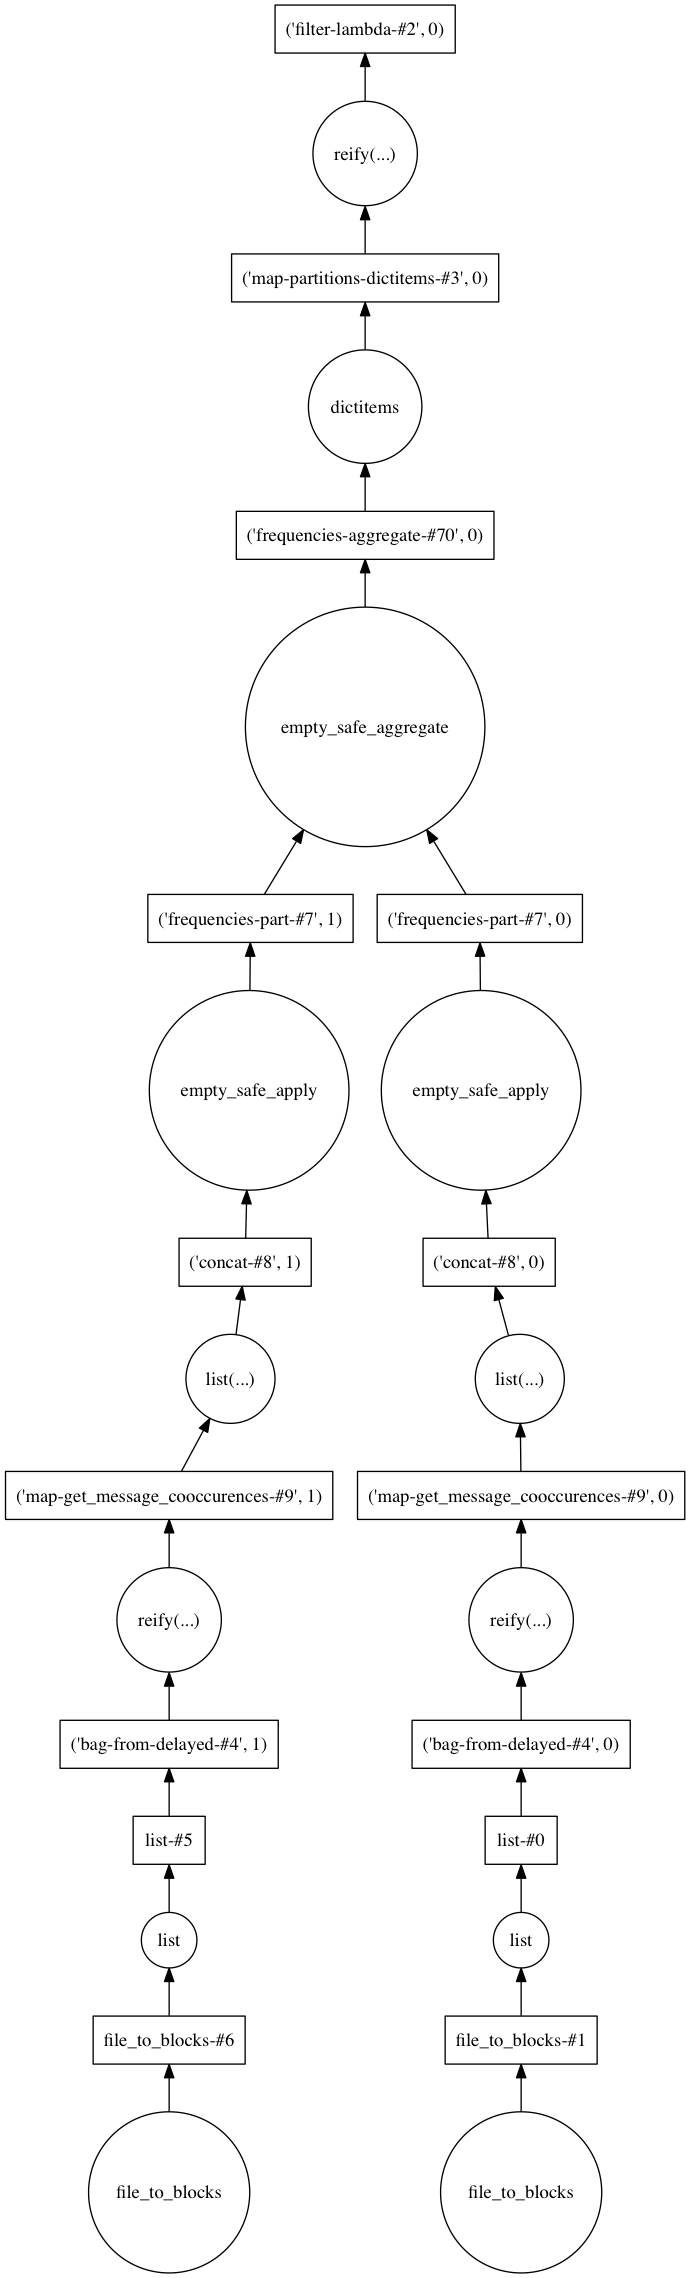

In [7]:
over_threshold.visualize()

In [23]:
cooccurences = db.read_text(tw_files).map(homer.parser.get_message_cooccurences,
                                          languages=languages).concat()

#cooccurences.take(3)
frequencies = cooccurences.frequencies()

#over_threshold = frequencies.filter(lambda x: x[1] > keep_threshold)
frequencies.remove(lambda x: x[1] < keep_threshold)

#frequencies = cooccurences.frequencies()
# dicts = frequencies.map(
#        lambda x: {'Date': int(x[0][0]),
#                    'W1': str(x[0][1]),
#                    'W2': str(x[0][2]),
#                    'Count': int(x[1])})
#     df = dicts.to_dataframe()

with ProgressBar():
    out = frequencies.take(3)
    #size = frequencies.count().compute()
    
print(size)

out

[########################################] | 100% Completed | 48.3s


((('20150615', 'dont', 'gone'), 4),
 (('20150615', 'lmao', 'take'), 6),
 (('20150615', 'give', 'women'), 2))

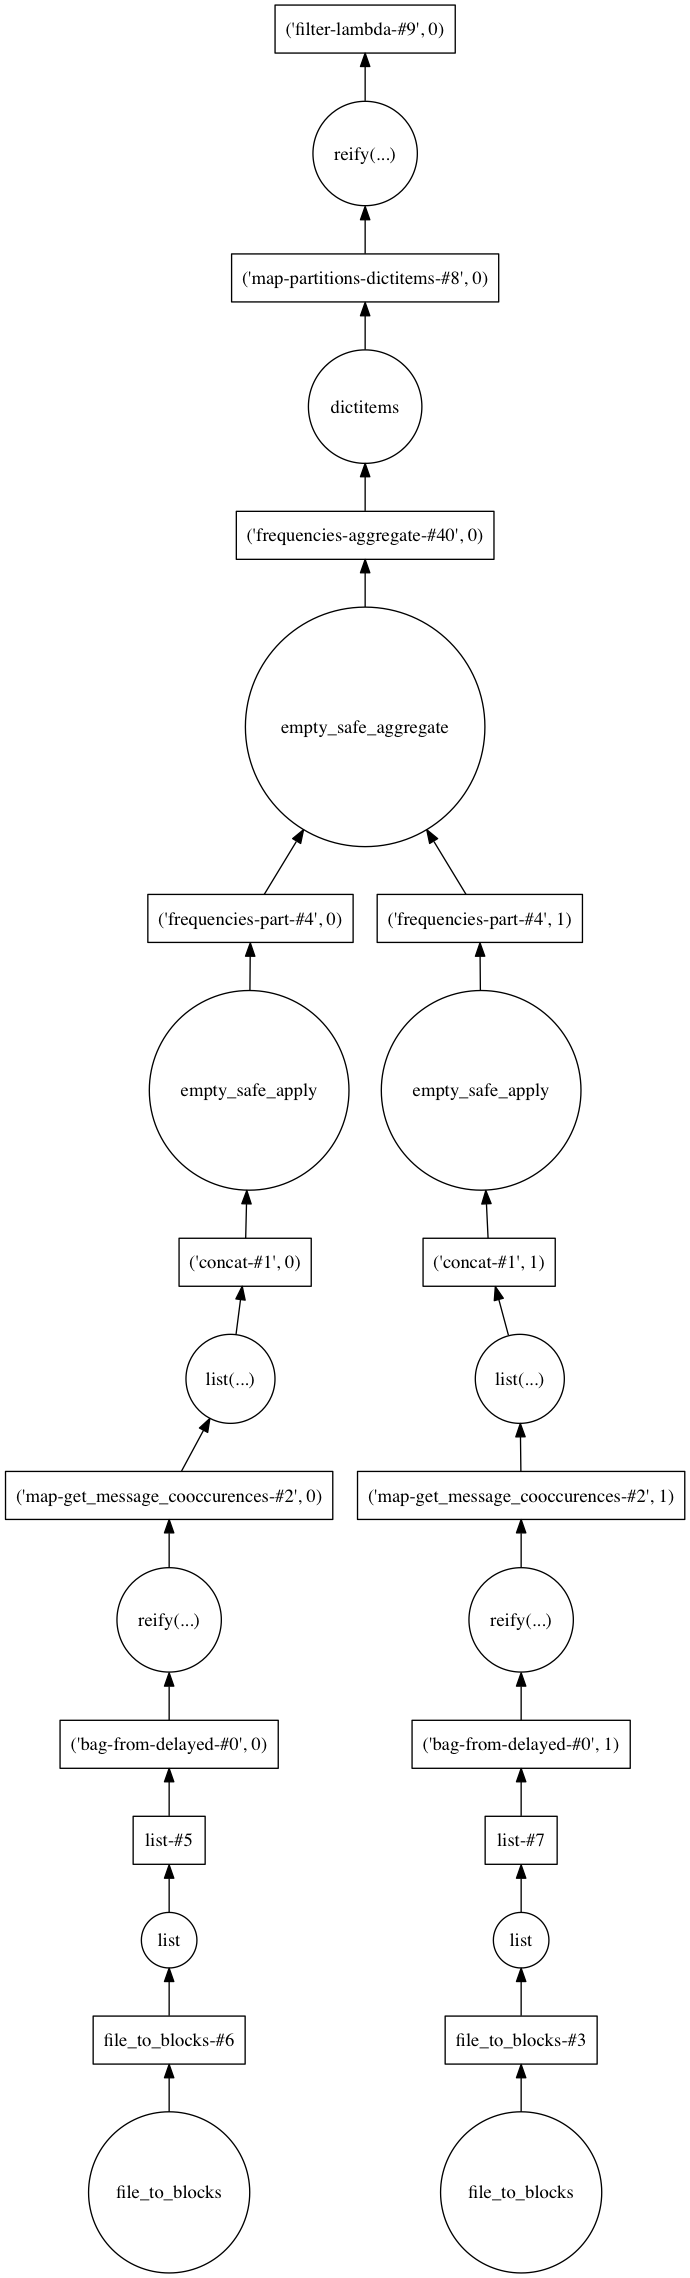

In [20]:
over_threshold.visualize()

In [4]:
df = homer.parser.get_weighted_edgelist(tw_files='tests/resources/testfile.txt',
                                        languages=['en'])


TypeError: apply() got an unexpected keyword argument 'languages'

Traceback
---------
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 268, in execute_task
    result = _execute_task(task, data)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 248, in _execute_task
    args2 = [_execute_task(a, cache) for a in args]
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 248, in <listcomp>
    args2 = [_execute_task(a, cache) for a in args]
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 248, in _execute_task
    args2 = [_execute_task(a, cache) for a in args]
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 248, in <listcomp>
    args2 = [_execute_task(a, cache) for a in args]
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 248, in _execute_task
    args2 = [_execute_task(a, cache) for a in args]
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 248, in <listcomp>
    args2 = [_execute_task(a, cache) for a in args]
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 249, in _execute_task
    return func(*args2)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/bag/core.py", line 1623, in empty_safe_apply
    _, part = peek(part)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/toolz/itertoolz.py", line 903, in peek
    item = next(iterator)


In [2]:
collection = homer.Homer(weighted_edge_list_globstring='tests/resources/Making_Connections_Generated_Data.hdf')                   

In [3]:
collection.compute_clusters('working/MC_gen_clusters_*.hdf', min_threshold=2)

In [4]:
collection.compute_relations('working/MC_gen_relations_*.hdf')

TypeError: Cannot serialize the column [children] because
its data contents are [mixed] object dtype

Traceback
---------
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 268, in execute_task
    result = _execute_task(task, data)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 249, in _execute_task
    return func(*args2)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/dataframe/io/hdf.py", line 35, in _pd_to_hdf
    pd_to_hdf(*args, **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/generic.py", line 1138, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 270, in to_hdf
    f(store)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 264, in <lambda>
    f = lambda store: store.put(key, value, **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 873, in put
    self._write_to_group(key, value, append=append, **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 1315, in _write_to_group
    s.write(obj=value, append=append, complib=complib, **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 4263, in write
    obj=obj, data_columns=data_columns, **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 3853, in write
    **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 3525, in create_axes
    raise e
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 3520, in create_axes
    **kwargs)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 1891, in set_atom
    encoding)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/io/pytables.py", line 1923, in set_atom_string
    % (item, inferred_type)


In [14]:
collection.compute_transition_clusters('working/MC_gen_transitions_*.hdf', min_threshold=3)

In [9]:
collection.transition_clusters.visualize()

In [2]:
collection = homer.Homer(clusters_globstring='working/MC_gen_clusters_*.hdf', 
                         transition_clusters_globstring='working/MC_gen_transitions_*.hdf')

In [3]:
collection.compute_transition_list('working/MC_gen_transitions_list.pickle')

In [15]:
collection.compute_tree(tree_filename='working/MC_gen_tree.json.gz')

AttributeError: 'NoneType' object has no attribute 'k_children'

In [ ]:
%debug


> /Users/houghton/Google Drive/Academic Projects/HOMER/homer/homer/tree.py(175)walk_k_ancestry()
    173         yield tree
    174 
--> 175     for child in tree.k_children:
    176         for elem in walk_k_ancestry(child, order):
    177             yield elem

ipdb> tree
ipdb> u
*** Oldest frame
ipdb> quit


In [12]:
collection = homer.Homer(weighted_edge_list_globstring='tests/resources/Making_Connections_Generated_Data.hdf',
                         clusters_globstring='working/MC_gen_clusters_*.hdf', 
                         #relations_globstring='working/MC_gen_relations_*.hdf',
                         transition_clusters_globstring='working/MC_gen_transitions_*.hdf',
                         transitions_filename='working/MC_gen_transitions_list.pickle',
                         #tree_filename='working/MC_gen_tree.json.gz'
                        )

In [ ]:
files = glob.glob('../../../mnt/nfs-marketdepth/houghton/data/twitter/raw/posts_sample_20150618*')

# pick up from saved

In [2]:
collection = homer.Homer(tree_filename='working/MC_gen_tree.json.gz')

In [3]:
tree = collection.tree

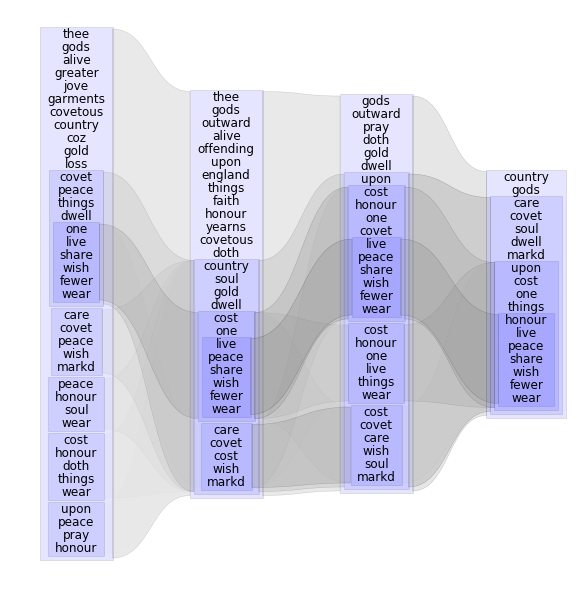

In [5]:
homer.tree.draw_series(node, 3)

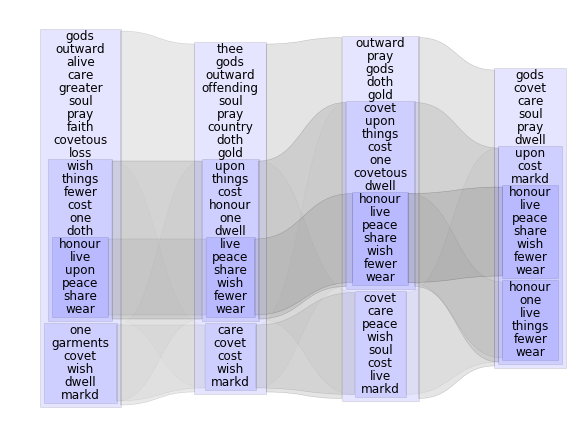

In [18]:
homer.tree.draw_series(tree.find("12"),3)

In [33]:
collection.clusters.reset_index(drop=True).compute()

Set  k  threshold  Date
0                             live one wish peace wear  3          6     1
1                 live wish wear one fewer share peace  3         13     3
2                 live wish wear one fewer share peace  3         12     3
3                 live wish wear one fewer share peace  3         11     3
4                 live wish wear one fewer share peace  3         10     3
5                 live wish wear one fewer share peace  3          5     1
6    live yearns desires dwell offending pray peace...  3          1     2
7                           care markd wish covet cost  5          4     2
8    live yearns desires dwell offending gods pray ...  3          1     1
9                           care markd wish covet cost  5          3     2
10                          care markd wish covet cost  5          2     2
11                                  one offending gold  3          3     1
12   live wish covet wear one care honour fewer sha...  4          3     4
13   live wish wear one honour fewer share upon dot...  5          2     1
14   live wish wear one honour fewer share things p...  4          6     3
15   live wish wear one honour fewer share things p...  4          6     4
16   live yearns dwell offending gods peace pray go...  3          2     1
17   live offending gods peace gold covet country f...  3          4     2
18         live wish wear one honour fewer share peace  5          4     3
19                                     wish covet soul  3          7     3
20   live yearns desires dwell offending pray peace...  3          1     3
21         live wish wear one honour fewer share peace  5          6     4
22   live yearns dwell offending pray gods peace go...  3          2     4
23   live wish wear one care honour fewer share thi...  3          6     4
24   live things wish covet wear one honour fewer s...  3          4     4
25        live wish wear honour fewer share upon peace  6          1     3
26        live wish wear honour fewer share upon peace  6          1     4
27             live wish wear honour fewer share peace  3         12     4
28   live desires dwell offending pray peace gods g...  4          1     2
29   live things wish covet wear one pray honour fe...  3          3     3
..                                                 ... ..        ...   ...
161                wish covet one markd dwell garments  6          1     1
162                         peace wish wear live share  4         10     2
163                               live wish fewer wear  3         21     4
164                               live wish fewer wear  3         18     4
165            live wear honour fewer share upon peace  7          1     1
166                         peace wish wear live share  4          9     2
167                                    wish peace wear  3         14     2
168                                    wish peace wear  3         12     2
169                                    wish peace wear  3         13     2
170                   live wish share markd care peace  6          1     1
171  live dwell gods peace pray covet fewer covetou...  4          2     1
172        live wish wear one fewer share things peace  3          8     2
173          live wish wear one fewer share peace cost  5          3     2
174  live wish wear one honour fewer share dwell th...  3          7     3
175                         live wish peace fewer wear  4         15     4
176                         live wish peace fewer wear  4         14     4
177                         live wish peace fewer wear  4         12     4
178                         live wish peace fewer wear  4         11     4
179                         live wish peace fewer wear  4         16     4
180                wish covet one markd dwell garments  5          2     1
181                                covetous peace soul  3          4     2
182  live dwell pray gods peace gold covet fewer co...  4          2     3
1

In [31]:
df = collection.clusters.compute()

In [32]:
df

Set  k  \
ID                                                                           
-9056716754200133287                           live one wish peace wear  3   
-8968590625581934390               live wish wear one fewer share peace  3   
-8968589172093433065               live wish wear one fewer share peace  3   
-8968587718594951140               live wish wear one fewer share peace  3   
-8968586265106449815               live wish wear one fewer share peace  3   
-8968578997651467440               live wish wear one fewer share peace  3   
-8851245618890672828  live yearns desires dwell offending pray peace...  3   
-8782763083573580906                         care markd wish covet cost  5   
-8665238872588369456  live yearns desires dwell offending gods pray ...  3   
-8782761630077594131                         care markd wish covet cost  5   
-8782760176586597656                         care markd wish covet cost  5   
-8393541618390397932                                 one offending gold  3   
-8519444988177512212  live wish covet wear one care honour fewer sha...  4   
-8152749116668198460  live wish wear one honour fewer share upon dot...  5   
-8093785111519984230  live wish wear one honour fewer share things p...  4   
-8093785111513746355  live wish wear one honour fewer share things p...  4   
-7342611274211033592  live yearns dwell offending gods peace pray go...  3   
-7849213218339514671  live offending gods peace gold covet country f...  3   
-7779879513127812350        live wish wear one honour fewer share peace  5   
-7471294687119695676                                    wish covet soul  3   
-7264323408483148274  live yearns desires dwell offending pray peace...  3   
-7779882420103567425        live wish wear one honour fewer share peace  5   
-7491867704463080922  live yearns dwell offending pray gods peace go...  3   
-7367565852801133305  live wish wear one care honour fewer share thi...  3   
-7263104398676613317  live things wish covet wear one honour fewer s...  3   
-7206458003605219759       live wish wear honour fewer share upon peace  6   
-7206458003601477034       live wish wear honour fewer share upon peace  6   
-7187102625537158327            live wish wear honour fewer share peace  3   
-6833523503610255049  live desires dwell offending pray peace gods g...  4   
-7091282485434342880  live things wish covet wear one pray honour fe...  3   
...                                                                 ... ..   
 6311707089933535154                wish covet one markd dwell garments  6   
 6611580787920279956                         peace wish wear live share  4   
 5969876539278286194                               live wish fewer wear  3   
 5969883806733268569                               live wish fewer wear  3   
 6641384811082465675            live wear honour fewer share upon peace  7   
 6611582241406286131                         peace wish wear live share  4   
 6692505083020759889                                    wish peace wear  3   
 6692507989997762539                                    wish peace wear  3   
 6692509443488759014                                    wish peace wear  3   
 6987276139892829842                   live wish share markd care peace  6   
 7059596737545879740  live dwell gods peace pray covet fewer covetou...  4   
 7108457513671634510        live wish wear one fewer share things peace  3   
 7145298420294494470          live wish wear one fewer share peace cost  5   
 7111286664576311072  live wish wear one honour fewer share dwell th...  3   
 6750579505135713335                         live wish peace fewer wear  4   
 6750580958616729210                         live wish peace fewer wear  4   
 6750583865598722160                         live wish peace fewer wear  4   
 6750585319089718635                         live wish peace fewer wear  4   
 6750624563356604060                         live wish peace fewer wear  4   
 78851517913

In [11]:
a = collection.clusters[collection.clusters['k']==7].compute()
a

Set  k  threshold  \
ID                                                                            
-6164480443017821638  upon fewer live honour wear share peace  7          1   

                      Date  
ID                          
-6164480443017821638     1

In [14]:
child = root.find(str(a.index[0]))
child.k_children

[share, upon, peace, fewer, live, honour, wear]

In [17]:
b = collection.clusters[collection.clusters['k']==6][collection.clusters['Date']==1].compute()
b

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py:249: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*args2)


Set  k  \
ID                                                                           
-8448021559611643807  dwell upon covet wish markd things fewer live ...  6   
-6704097345979941056                   care markd wish live share peace  6   
-1292011934155600227                dwell markd covet wish garments one  6   
-51002126403807112         care doth markd wish things live honour gods  6   
 2617171587878002598                  upon live honour wear share peace  6   
 3394883846396084971                  care dwell markd covet wish share  6   

                      threshold  Date  
ID                                     
-8448021559611643807          1     1  
-6704097345979941056          1     1  
-1292011934155600227          1     1  
-51002126403807112            1     1  
 2617171587878002598          2     1  
 3394883846396084971          1     1

In [27]:
b = collection.clusters[collection.clusters['k']==5][collection.clusters['Date']==1].compute()
b

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py:249: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*args2)


Set  k  \
ID                                                                           
-6184392761650886715                dwell markd garments covet wish one  5   
-3101355562922971180                     wish fewer live wear one share  5   
 360431357983146192   dwell upon markd garments doth jove wear engla...  5   
 7925733623849426782  doth upon wish things fewer live honour wear o...  5   

                      threshold  Date  
ID                                     
-6184392761650886715          2     1  
-3101355562922971180          3     1  
 360431357983146192           1     1  
 7925733623849426782          2     1

In [28]:
parent = root.find('360431357983146192')
parent.k_children

[-8448021559611643807,
 -6704097345979941056,
 -1292011934155600227,
 -51002126403807112,
 3394883846396084971,
 jove,
 coz,
 soul,
 thee,
 england,
 gold,
 country,
 alive,
 faith,
 covetous,
 greater,
 yearns]

In [29]:
for n in homer.tree.walk_k_ancestry(parent):
    print(n, n.k_children)

share []
upon []
peace []
fewer []
live []
honour []
wear []
-6164480443017821638 [share, upon, peace, fewer, live, honour, wear]
dwell []
markd []
covet []
wish []
things []
pray []
one []
cost []
outward []
-8448021559611643807 [-6164480443017821638, dwell, markd, covet, wish, things, pray, one, cost, outward]
care []
share []
markd []
wish []
live []
peace []
-6704097345979941056 [care, share, markd, wish, live, peace]
dwell []
markd []
garments []
covet []
wish []
one []
-1292011934155600227 [dwell, markd, garments, covet, wish, one]
care []
doth []
markd []
wish []
things []
live []
honour []
gods []
-51002126403807112 [care, doth, markd, wish, things, live, honour, gods]
care []
dwell []
markd []
covet []
wish []
share []
3394883846396084971 [care, dwell, markd, covet, wish, share]
jove []
coz []
soul []
thee []
england []
gold []
country []
alive []
faith []
covetous []
greater []
yearns []
360431357983146192 [-8448021559611643807, -6704097345979941056, -1292011934155600227, -51

In [35]:
list(zip((1,2), (11, 22), (111, 222)))

[(1, 11, 111), (2, 22, 222)]

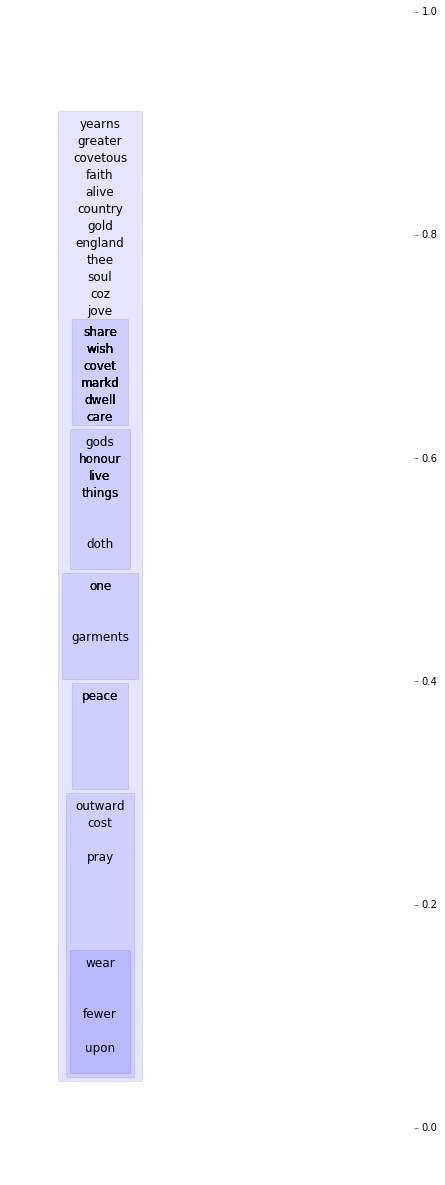

In [33]:
fig = plt.figure(figsize=(7,20))
ax = plt.gca()
ax_test = ax.twinx()
parent.layout(ax_test)
parent.set_bottom(100)
parent.set_center(100)
parent.draw(ax)

In [22]:
parent.draw()

TypeError: draw() missing 1 required positional argument: 'ax'

In [ ]:
a.k_children[2] is b.k_children[5]

In [31]:
collection.clusters[collection.clusters['k']==7].compute()

Set  k  threshold  \
ID                                                                            
-2943944007688239924  peace share live upon honour wear fewer  7          1   

                      Date  
ID                          
-2943944007688239924     1

In [37]:
collection.clusters[(collection.clusters['k']==6)].compute()

Set  k  \
ID                                                                           
-8596872330028569940            peace share live wish fewer honour wear  6   
-8596875237009315315            peace share live wish fewer honour wear  6   
-8596870876536325890            peace share live wish fewer honour wear  6   
-5853114226745766784       peace share live wish wear fewer honour upon  6   
-4702866424366699832  outward peace share live pray markd wish dwell...  6   
-2948239378724855240                  care share markd wish dwell covet  6   
-3346707278463544760             live one fewer honour things wear cost  6   
-3172245855120495490                  live one fewer honour things wear  6   
-2861959016774172950            peace share live wish wear fewer honour  6   
-1528199568099632733                  one fewer honour things cost wear  6   
 330078396478804253        care live markd wish gods honour things doth  6   
 1978613721519484956                   care peace share live markd wish  6   
 2465779725107811867             live one things fewer honour cost wear  6   
 3587854818817345375       peace share live wish fewer honour wear upon  6   
 4474364821107741738                markd wish dwell one garments covet  6   
 4513977423615979025                  peace share live upon honour wear  6   
 6076125180958487158                   peace share live wish wear fewer  6   
 6076125180954744433                   peace share live wish wear fewer  6   
 6076126634446988483                   peace share live wish wear fewer  6   
 6076128087945470408                   peace share live wish wear fewer  6   
 6076129541433971733                   peace share live wish wear fewer  6   
 6076126634455721508                   peace share live wish wear fewer  6   
 6076128087946717983                   peace share live wish wear fewer  6   
 6076129541427733858                   peace share live wish wear fewer  6   
 6076130994921225483                   peace share live wish wear fewer  6   
 6076130994922473058                   peace share live wish wear fewer  6   
 6076132448412221958                   peace share live wish wear fewer  6   
 6076133901908208733                   peace share live wish wear fewer  6   
 6076135355399205208                   peace share live wish wear fewer  6   
 6076136808885211383                   peace share live wish wear fewer  6   
 6076132448410974383                   peace share live wish wear fewer  6   
 6076133901909456308                   peace share live wish wear fewer  6   
 6076130994928710933                   peace share live wish wear fewer  6   
 7301446003518818204             care peace share live markd wish covet  6   

                      threshold  Date  
ID                                     
-8596872330028569940          2     3  
-8596875237009315315          4     4  
-8596870876536325890          3     4  
-5853114226745766784          1     3  
-4702866424366699832          1     1  
-2948239378724855240          1     1  
-3346707278463544760          1     3  
-3172245855120495490          2     4  
-2861959016774172950          2     4  
-1528199568099632733          1     2  
 330078396478804253           1     1  
 1978613721519484956          1     1  
 2465779725107811867          1     4  
 3587854818817345375          1     4  
 4474364821107741738          1     1  
 4513977423615979025          2     1  
 6076125180958487158          9     3  
 6076125180954744433          9     4  
 6076126634446988483          8     3  
 6076128087945470408          7     3  
 6076129541433971733          6     3  
 6076126634455721508          8     4  
 6076128087946717983          7     4  
 6076129541427733858          6     4  
 6076130994921225483          5     2  
 6076130994922473058          5     3  
 6076132448412221958          4     2  
 6076133901908208733          3     2  
 6076135355399205208          2     2  
 607613680888521138